In [1]:
#%pip install --upgrade https://storage.googleapis.com/tensorflow/mac/cpu/tensorflow-1.0.0-py3-none-any.whl
%pip install   opencv-python mediapipe sklearn matplotlib numpy


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


<h1><span style = "color:blue">1) Importing and installing dependencies</span></h1>

In [2]:
import cv2
import numpy as np #going to be used extensively for array operations
import os #helps with filepaths
from matplotlib import pyplot as plt
import time #to provide sleep times between frames being captured
import mediapipe as mp#for all the keypoints and hand detection going to be used to train our model


<h1><span style = "color:blue">2) Detection of Face, Hand and Pose landmarks </span></h1>

In [3]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities


In [4]:
#cv2 captures frames of the video in bgr color and mediapipe accepts rgb color so we need to convert the color
def mediaPipeDetection(image, model):

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #converts bgr to rgb
    image.flags.writeable = False #image is not writable
    results = model.process(image) #making the prediction by our mediapipe model
    image.flags.writeable = True #image is writable
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) #converts rgb to bgr
    return image, results

In [5]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) #draws face landmarks
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) #draws left hand landmarks
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) #draws right hand landmarks
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) #draws pose landmarks

In [6]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION,mp_drawing.DrawingSpec(color = (80,110,10),thickness=1,circle_radius=1),mp_drawing.DrawingSpec(color = (80,256,121),thickness=1,circle_radius=1))#draws face landmarks,changin the dot color and connection colors
    
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,mp_drawing.DrawingSpec(color = (80,22,10),thickness=2,circle_radius=4),mp_drawing.DrawingSpec(color = (80,44,121),thickness=2,circle_radius=2))#draws left hand landmarks
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,mp_drawing.DrawingSpec(color = (121,22,76),thickness=2,circle_radius=4),mp_drawing.DrawingSpec(color = (121,44,250),thickness=2,circle_radius=2))#draws right hand landmarks
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,mp_drawing.DrawingSpec(color = (245,117,66),thickness=2,circle_radius=4),mp_drawing.DrawingSpec(color = (245,66,230),thickness=2,circle_radius=2))#draws pose landmarks

In [7]:
cap = cv2.VideoCapture(0) #capture video from webcam
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic: #Holistic model with confidence levels

    while cap.isOpened():
        ret,frame = cap.read() #read the frames

        image,results = mediaPipeDetection(frame,holistic)

        draw_landmarks(image,results)

        cv2.imshow('OpenCV feed',image) #show the frames

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()#shuts the webcam
    cv2.destroyAllWindows()


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [11]:
#mp_drawing.draw_landmarks??

<h1><span style = "color:blue">3) Extract Keypoint values</span></h1>

In [8]:
len(results.face_landmarks.landmark)

468

In [9]:
draw_landmarks(frame,results)#applying the frame and results to the draw_landmarks function

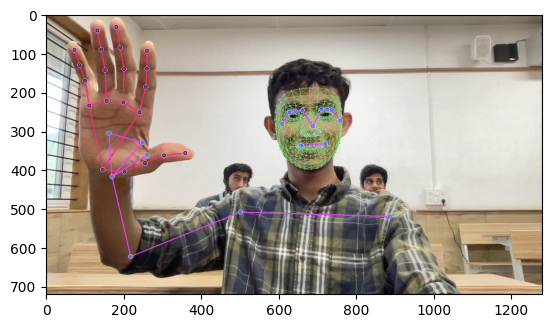

In [10]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [11]:
len(results.face_landmarks.landmark)

468

In [12]:
pose=[]
for res in results.pose_landmarks.landmark:
    test = np.array([res.x,res.y,res.z,res.visibility])#equivalent to results.pose_landmarks.landmark[0].x,results.pose_landmarks.landmark[0].y,results.pose_landmarks.landmark[0].z,results.pose_landmarks.landmark[0].visibility
    pose.append(test)
pose



[array([ 0.53796178,  0.4013232 , -0.51326972,  0.99997455]),
 array([ 0.55538213,  0.33991954, -0.46934479,  0.99995238]),
 array([ 0.56685889,  0.3412596 , -0.46917781,  0.99994105]),
 array([ 0.57610363,  0.34299695, -0.46929941,  0.99995369]),
 array([ 0.51718199,  0.34372586, -0.45994821,  0.99995625]),
 array([ 0.5029549 ,  0.34652647, -0.45951539,  0.99995035]),
 array([ 0.49108568,  0.35031164, -0.45959124,  0.99996638]),
 array([ 0.59330893,  0.38158044, -0.22312367,  0.99993742]),
 array([ 0.47606549,  0.39251417, -0.17070995,  0.9999615 ]),
 array([ 0.56280309,  0.46318367, -0.4296318 ,  0.99997258]),
 array([ 0.51462007,  0.47050244, -0.41515177,  0.99997884]),
 array([ 0.69318402,  0.7229718 , -0.13908598,  0.99953693]),
 array([ 0.39146963,  0.70802212, -0.07934504,  0.99976176]),
 array([ 0.79713869,  1.12126517, -0.19838223,  0.61739177]),
 array([ 0.17107569,  0.86591887, -0.4288353 ,  0.98290545]),
 array([ 0.81402719,  1.48094141, -0.36267254,  0.32988793]),
 array([

In [13]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)#its 4 * 33 for pose since it has an extra visibility parameter
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [14]:
extract_keypoints(results).shape

(1662,)

<h1><span style = "color:blue">4) Setup Folders for Collection</span></h1><br>

<p><span style = "font-family:'Bebas Neue'">For each action there will be a folder containing 30 videos of 30 frames each</span></p>

In [15]:
#Path for the exported data that is the numpy arrays

DATA_PATH = os.path.join('MP_Data') #creating a folder for the data

#Actions that we try to detect

actions = np.array(['hello', 'thanks', 'iloveyou'])

#number of videos we want to record for each action
no_sequences = 30 #number of sequences for each action

#number of frames for each video
sequence_length = 30 #number of frames in each sequence

In [20]:
for action in actions:
    for sequence in range(no_sequences):
        try:
            os.makedirs(os.path.join(DATA_PATH,action,str(sequence))) #creating a folder for each action and sequence
        except:
            pass #if the folder already exists, it will pass
        

<h1><span style = "color:blue">5) Collect Keypoint values for Training and Testing</span></h1><br>
<h1>Where do we put in the wait time?</h1>

In [21]:
cap = cv2.VideoCapture(0) #capture video from webcam

#set the media pipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic: #Holistic model with confidence levels

    for action in actions:
        for sequence in range(no_sequences):
            for frame_num in range(sequence_length):

                #read feed
                ret, frame = cap.read()

                #make detections

                image,results = mediaPipeDetection(frame,holistic)

                draw_landmarks(image,results)

                #APPLYING THE WAIT LOGIC IN ORDER TO INTRODUCE A DELAY BETWEEN CAPTURING  FRAMES
                #THIS WILL ALLOWS US TO GET THE BEST RESULTS
                if frame_num == 0:
                    cv2.putText(image,'STARTING COLLECTION',(120,200),cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),4,cv2.LINE_AA)
                    cv2.putText(image,'Collecting frames for {} Video Number {}'.format(action,sequence),(15,12),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,255),1,cv2.LINE_AA)
                    cv2.imshow('OpenCV Feed',image)
                    cv2.waitKey(2000)
                else:
                    cv2.putText(image,'Collecting frames for {} Video Number {}'.format(action,sequence),(15,12),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,255),1,cv2.LINE_AA)
                    cv2.imshow('OpenCV Feed',image)

                #EXPORTING EACH OP THE KEYPOINTS TO THE FOLDER CREATED
                keypoints = extract_keypoints(results)#we get a numpy array of the keypoints
                npy_path = os.path.join(DATA_PATH,action,str(sequence),str(frame_num))
                np.save(npy_path,keypoints)

                #break when the user presses q
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break

cap.release()
cv2.destroyAllWindows()


<h1><span style = "color:blue">6) Preprocess Data and create labels and features</span></h1><br>

In [4]:
# #%python3 -m pip install tensorflow-macos
# from sklearn.model_selection import train_test_split
# from tensorflow.keras.utils import to_categorical


In [35]:
label_map = {label:num for num,label in enumerate(actions)}
label_map

{'hello': 0, 'thanks': 1, 'iloveyou': 2}

In [36]:
sequences,labels = [],[]
for action in actions:
    for sequence in range(no_sequences):
        window =[]
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH,action,str(sequence),str(frame_num)+'.npy'))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])


In [37]:
np.array(sequences).shape

(90, 30, 1662)

In [31]:
np.array(labels).shape

(90,)

In [38]:
x = np.array(sequences)
x.shape

(90, 30, 1662)

In [5]:
#y = to_categorical(labels).astype(int)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.05)

In [ ]:
y_test.shape

<h1><span style = "color:blue">7) Building and Training the LSTM Model </span></h1><br>

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [ ]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [ ]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [ ]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model.fit(X_train, y_train, epochs=2000, callbacks=[tb_callback])

In [ ]:
model.summary()

<h1><span style = "color:blue">8) Make Predictions </span></h1><br>

In [ ]:
res = model.predict(X_test)

In [ ]:
actions[np.argmax(res[4])]

In [ ]:
actions[np.argmax(y_test[4])]

<h1><span style = "color:blue">9)Save weights</span></h1><br>

In [ ]:
model.save('action.h5')

In [ ]:
model.load_weights('action.h5')

<h1><span style = "color:blue">10) Evaluation using Confusion matrix</span></h1><br>

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [ ]:
yhat = model.predict(X_test)

In [ ]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [ ]:
multilabel_confusion_matrix(ytrue, yhat)

In [ ]:
accuracy_score(ytrue, yhat)

<h1><span style = "color:blue">11) Test in Real Time </span></h1><br>

In [ ]:
from scipy import stats

In [ ]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [ ]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))

In [ ]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()